In [ ]:
!pip install catboost
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from nltk.tokenize import word_tokenize
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
from nltk.corpus import wordnet as wn
from nltk.corpus import sentiwordnet as swn
import nltk
import optuna
from sklearn.model_selection import train_test_split
from wordcloud import STOPWORDS
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
import re
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
test = pd.read_csv('test.csv')
train = pd.read_csv('train.csv')

In [ ]:
train['content'] = train.Title + ' ' + train.Description
labels = train["Class Index"]
test['content'] = test.Title + ' ' + test.Description
test_labels = test['Class Index']

In [ ]:
test_labels = test['Class Index']

In [ ]:
def normalise_text(text):
    text = text.lower()  # lowercase
    text = text.replace(r"\#", "")  # replaces hashtags
    text = text.replace(r"http\S+", "URL")  # remove URL addresses
    text = text.replace(r"@", "")
    text = text.replace(r"[^A-Za-z0-9()!?\'\`\"]", " ")
    text = text.replace("\s{2,}", " ")
    return text

In [ ]:
def datacleaning(text):
    whitespace = re.compile(r"\s+")
    user = re.compile(r"(?i)@[a-z0-9_]+")
    text = whitespace.sub(' ', text)
    text = user.sub('', text)
    text = re.sub(r"\[[^()]*\]","", text)
    text = re.sub("\d+", "", text)
    text = re.sub(r'[^\w\s]','',text)
    text = re.sub(r"(?:@\S*|#\S*|http(?=.*://)\S*)", " ", text)
    text = text.lower()
    
    # removing stop-words
    text = [word for word in text.split() if word not in list(STOPWORDS)]
    # text = [word for word in text.split()]
    
    # word lemmatization
    # sentence = []
    # snow_stemmer = SnowballStemmer(language='english')
    # for word in text:
        # lemmatizer = WordNetLemmatizer()
        # sentence.append(snow_stemmer.stem(word))
        # sentence.append(lemmatizer.lemmatize(word,'v'))
        # sentence.append(lemmatizer.lemmatize(word))
        
    return ' '.join(text) 

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
# train.content = train.content.apply(normalise_text)
# test.content = test.content.apply(normalise_text)
train.content = train.content.apply(datacleaning)
test.content = test.content.apply(datacleaning)

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(train, labels, test_size=0.2, random_state=42)

In [ ]:
bow_counts = CountVectorizer(tokenizer= word_tokenize, # type of tokenization
                             ngram_range=(1,2)) # number of n-grams

bow_train = bow_counts.fit_transform(X_train['content'])
bow_valid = bow_counts.transform(X_valid['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
bow_test = bow_counts.transform(test['content'])

In [ ]:
bow_train

<96000x1149521 sparse matrix of type '<class 'numpy.int64'>'
	with 7387408 stored elements in Compressed Sparse Row format>

In [ ]:
bow_test

<7600x1149521 sparse matrix of type '<class 'numpy.int64'>'
	with 523076 stored elements in Compressed Sparse Row format>

In [ ]:
models = [
    RandomForestClassifier(n_estimators=100, max_depth=5, random_state=0),
    LinearSVC(max_iter=10000),
    MultinomialNB(),
    LogisticRegression(random_state=0, max_iter=10000)
]

# 5 Cross-validation
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))

entries = []
for model in models:
    model_name = model.__class__.__name__
    print(model_name)
    accuracies = cross_val_score(model, bow_data, labels, scoring='accuracy', cv=CV, verbose=3, n_jobs=3)
    for fold_idx, accuracy in enumerate(accuracies):
        entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

RandomForestClassifier


[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:  2.2min remaining:  3.3min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:  3.5min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


LinearSVC


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed: 16.7min remaining: 25.0min


MultinomialNB


[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 29.1min finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.
[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed:    2.2s remaining:    3.3s
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed:    4.0s finished
[Parallel(n_jobs=3)]: Using backend LokyBackend with 3 concurrent workers.


LogisticRegression


[Parallel(n_jobs=3)]: Done   2 out of   5 | elapsed: 24.5min remaining: 36.7min
[Parallel(n_jobs=3)]: Done   5 out of   5 | elapsed: 43.1min finished


In [ ]:
mean_accuracy = cv_df.groupby('model_name').accuracy.mean()
std_accuracy = cv_df.groupby('model_name').accuracy.std()

acc = pd.concat([mean_accuracy, std_accuracy], axis= 1,
          ignore_index=True)
acc.columns = ['Mean Accuracy', 'Standard deviation']
acc

,Mean Accuracy,Standard deviation
model_name,,
LinearSVC,0.903125,0.009370
LogisticRegression,0.906475,0.008574
MultinomialNB,0.897708,0.010511
RandomForestClassifier,0.732883,0.010830


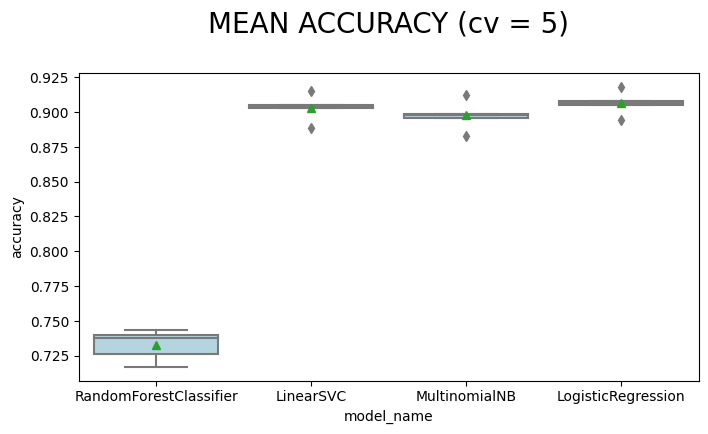

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(x='model_name', y='accuracy',
            data=cv_df,
            color='lightblue',
            showmeans=True)
plt.title("MEAN ACCURACY (cv = 5)\n", size=20);

In [ ]:
cat = CatBoostClassifier().fit(bow_data, labels, verbose=3)

Learning rate set to 0.101009
0:	learn: 1.3489234	total: 11.2s	remaining: 3h 6m 13s
3:	learn: 1.2680207	total: 44.5s	remaining: 3h 4m 48s
6:	learn: 1.2087098	total: 1m 18s	remaining: 3h 6m 3s
9:	learn: 1.1625819	total: 1m 52s	remaining: 3h 5m 14s
12:	learn: 1.1245351	total: 2m 25s	remaining: 3h 4m 22s
15:	learn: 1.0909683	total: 2m 58s	remaining: 3h 3m 13s
18:	learn: 1.0616592	total: 3m 31s	remaining: 3h 2m 8s
21:	learn: 1.0357238	total: 4m 4s	remaining: 3h 1m 15s
24:	learn: 1.0110453	total: 4m 38s	remaining: 3h 45s
27:	learn: 0.9907571	total: 5m 11s	remaining: 3h 11s
30:	learn: 0.9704668	total: 5m 45s	remaining: 2h 59m 57s
33:	learn: 0.9510577	total: 6m 19s	remaining: 2h 59m 37s
36:	learn: 0.9336738	total: 6m 52s	remaining: 2h 59m
39:	learn: 0.9181509	total: 7m 25s	remaining: 2h 58m 9s
42:	learn: 0.9023911	total: 7m 58s	remaining: 2h 57m 23s
45:	learn: 0.8887184	total: 8m 31s	remaining: 2h 56m 42s
48:	learn: 0.8758998	total: 9m 4s	remaining: 2h 56m 1s
51:	learn: 0.8638144	total: 9m 37

In [ ]:
y_pred = cat.predict(bow_test)

In [ ]:
def replace_labels(lst):
  result = []
  labels=['world', 'sports', 'business', 'sci-tech']
  for i in range(len(lst)):
      print(lst)
      #lst.lo[i] = labels[int(lst[i])-1]

In [ ]:
labels=['world', 'sports', 'business', 'sci-tech']
result = []
for each in y_pred: 
  result.append(labels[int(each) -1])

In [ ]:
labels=['world', 'sports', 'business', 'sci-tech']
preds = []
i = 0
for each in test_labels: 
  if i == 0:
    preds.append(each)
  else: 
    preds.append(labels[int(each) -1])
  i += 1
  #result.append(labels[int(each) -1])

Text(0.5, 1.0, 'CONFUSION MATRIX Catboost\n')

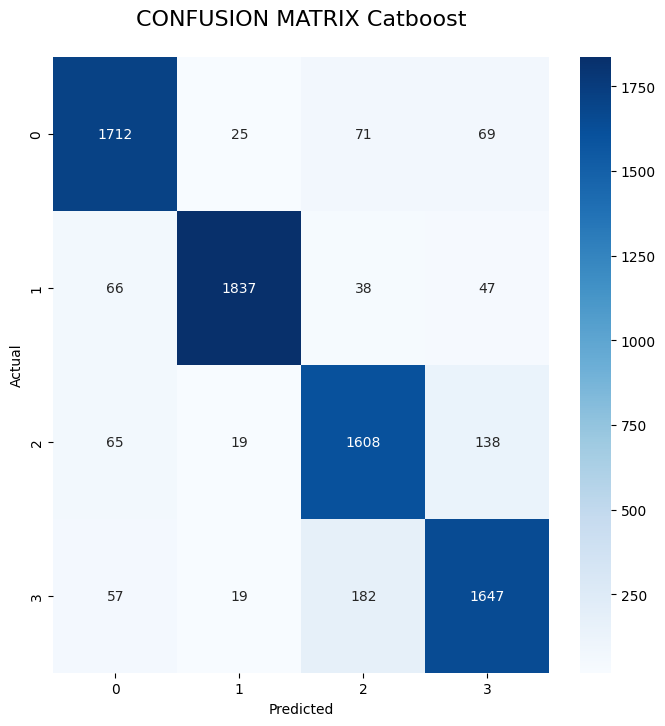

In [ ]:
conf_mat = metrics.confusion_matrix(result, preds, labels=['world', 'sports', 'business', 'sci-tech'])
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX Catboost\n", size=16)

array([[1712,   66,   65,   57],
       [  25, 1837,   19,   19],
       [  71,   38, 1609,  182],
       [  69,   47,  137, 1647]])

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.8953947368421052
F1 Score (Micro) = 0.8953947368421051
F1 Score (Macro) = 0.8949840090511589


Эксперимент 2

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-10 05:14:10,713] A new study created in memory with name: no-name-77d2dbd5-d8f3-4d0c-8a31-f73e84d53886
[I 2023-05-10 05:39:47,879] Trial 0 finished with value: 0.9213035661273947 and parameters: {'svc_c': 7.023831709453853}. Best is trial 0 with value: 0.9213035661273947.
[I 2023-05-10 05:41:12,047] Trial 1 finished with value: 0.9252398702013964 and parameters: {'svc_c': 0.1072435158110205}. Best is trial 1 with value: 0.9252398702013964.
[I 2023-05-10 06:00:31,605] Trial 2 finished with value: 0.9217629084725589 and parameters: {'svc_c': 4.396206602144244}. Best is trial 1 with value: 0.9252398702013964.
[I 2023-05-10 06:02:51,852] Trial 3 finished with value: 0.9245365511474399 and parameters: {'svc_c': 0.21872764993982985}. Best is trial 1 with value: 0.9252398702013964.
[I 2023-05-10 06:10:35,137] Trial 4 finished with value: 0.922682114994904 and parameters: {'svc_c': 1.4019630429211}. Best is trial 1 with value: 0.9252398702013964.
[I 2023-05-10 06:20:59,550] Trial 5 

In [ ]:
bow_data = bow_counts.fit_transform(train['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
bow_test = bow_counts.transform(test['content'])

In [ ]:
clf = LinearSVC(C=0.1, random_state=3, class_weight='balanced', max_iter=100000)
clf.fit(bow_data, labels)

LinearSVC(C=0.1, class_weight='balanced', max_iter=100000, random_state=3)

In [ ]:
y_pred = clf.predict(bow_test)

Text(0.5, 1.0, 'CONFUSION MATRIX Catboost\n')

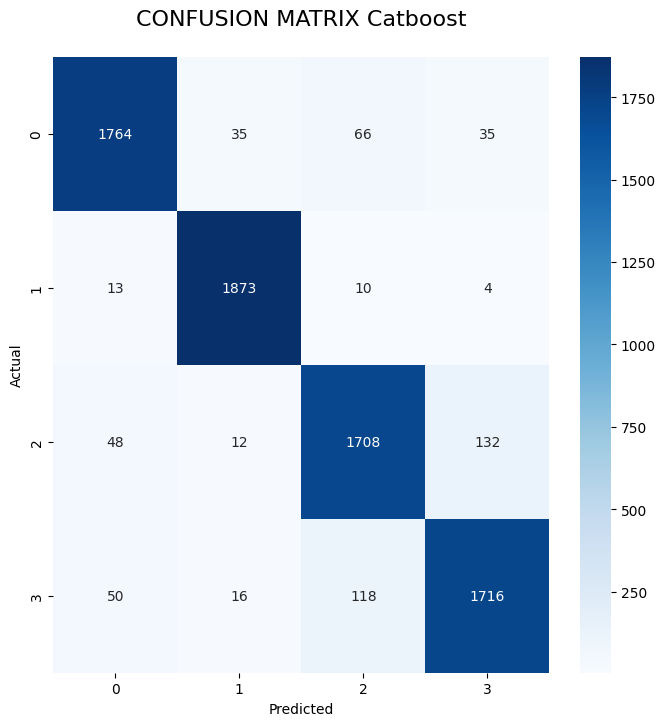

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX Catboost\n", size=16)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.929078947368421
F1 Score (Micro) = 0.929078947368421
F1 Score (Macro) = 0.9289600839824994


Эксперимен 3

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)

    clf = LogisticRegression(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-10 07:34:24,909] A new study created in memory with name: no-name-18682755-5af5-4073-be88-935ddc6327e0
[I 2023-05-10 07:40:49,658] Trial 0 finished with value: 0.9225023962191521 and parameters: {'svc_c': 0.3377065002444557}. Best is trial 0 with value: 0.9225023962191521.
[I 2023-05-10 07:48:27,165] Trial 1 finished with value: 0.922999971757072 and parameters: {'svc_c': 0.9038319702843758}. Best is trial 1 with value: 0.922999971757072.
[I 2023-05-10 07:53:39,302] Trial 2 finished with value: 0.9212069620564503 and parameters: {'svc_c': 0.14109321668319985}. Best is trial 1 with value: 0.922999971757072.
[I 2023-05-10 07:56:17,242] Trial 3 finished with value: 0.9147728242096915 and parameters: {'svc_c': 0.01715816745131199}. Best is trial 1 with value: 0.922999971757072.
[I 2023-05-10 08:03:29,406] Trial 4 finished with value: 0.9226650264413833 and parameters: {'svc_c': 0.56929981143608}. Best is trial 1 with value: 0.922999971757072.
[I 2023-05-10 08:10:41,837] Trial 5 

FrozenTrial(number=8, state=TrialState.COMPLETE, values=[0.9230831310826908], datetime_start=datetime.datetime(2023, 5, 10, 8, 29, 53, 410428), datetime_complete=datetime.datetime(2023, 5, 10, 8, 39, 12, 829769), params={'svc_c': 3.993684258430785}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.01, step=None)}, trial_id=8, value=None)


In [ ]:
bow_data = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LogisticRegression(C=4, random_state=3, class_weight='balanced', max_iter=100000)
clf.fit(bow_data, labels)

LogisticRegression(C=4, class_weight='balanced', max_iter=100000,
                   random_state=3)

In [ ]:
y_pred = clf.predict(bow_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.925921052631579
F1 Score (Micro) = 0.925921052631579
F1 Score (Macro) = 0.9257983549820087


Text(0.5, 1.0, 'CONFUSION MATRIX Catboost\n')

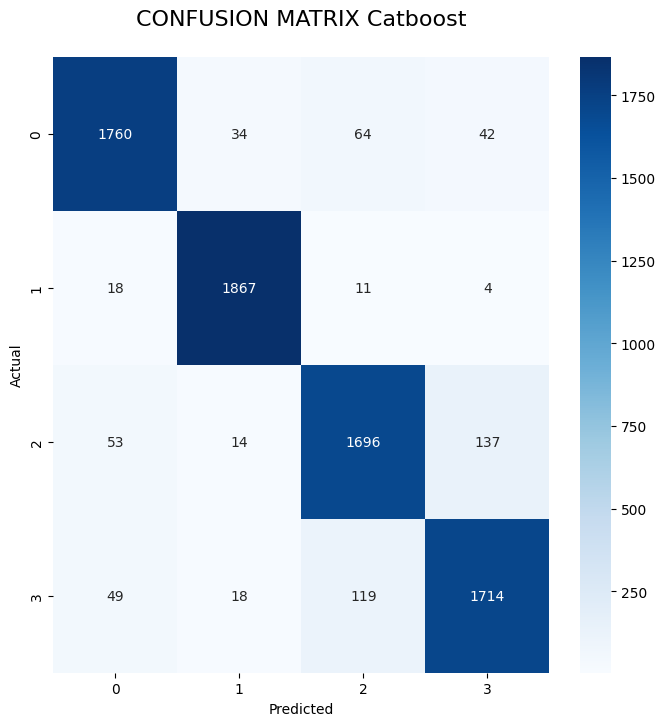

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX Catboost\n", size=16)

In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.93      0.93      1900
           2       0.97      0.98      0.97      1900
           3       0.90      0.89      0.89      1900
           4       0.90      0.90      0.90      1900

    accuracy                           0.93      7600
   macro avg       0.93      0.93      0.93      7600
weighted avg       0.93      0.93      0.93      7600



Эксперимен 4

In [ ]:
clf = MultinomialNB(force_alpha=True)
clf.fit(bow_data, labels)

MultinomialNB(force_alpha=True)

In [ ]:
y_pred = clf.predict(bow_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9069736842105263
F1 Score (Micro) = 0.9069736842105263
F1 Score (Macro) = 0.9067083396004869


Text(0.5, 1.0, 'CONFUSION MATRIX Catboost\n')

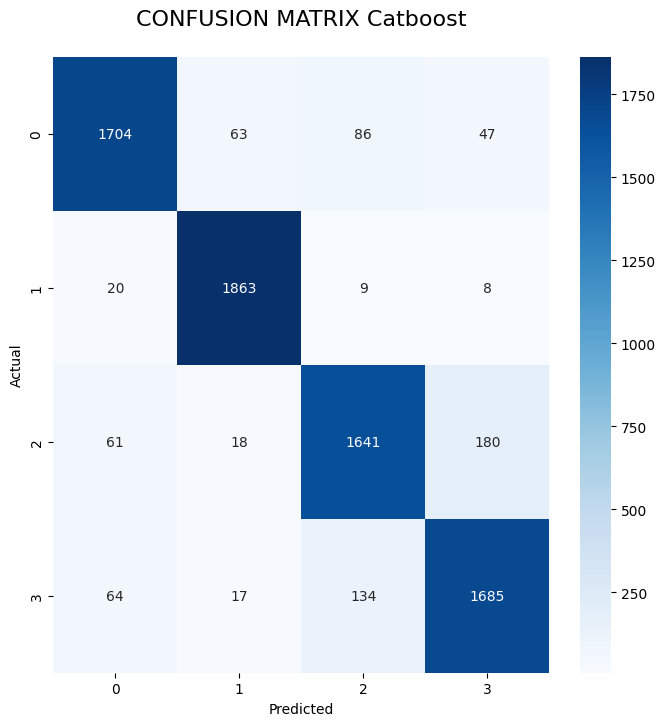

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX Catboost\n", size=16)

In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.98      0.97      1900
           3       0.88      0.86      0.87      1900
           4       0.88      0.89      0.88      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



Эксперимент 5 (Токен+удаление стоп-слов + лемматизация)

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-20 08:45:16,145] A new study created in memory with name: no-name-7f5b699f-9349-4d32-b633-96453d5612d9


In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("lr_c", 1e-1, 1e2, log=True)

    clf = LogisticRegression(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

In [ ]:
bow_data = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])

In [ ]:
clf = LinearSVC(C=0.1, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)

In [ ]:
y_pred = clf.predict(bow_test)

In [ ]:
#0.1
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9247368421052632
F1 Score (Micro) = 0.9247368421052632
F1 Score (Macro) = 0.9245902259198523


Text(0.5, 1.0, 'CONFUSION MATRIX Catboost\n')

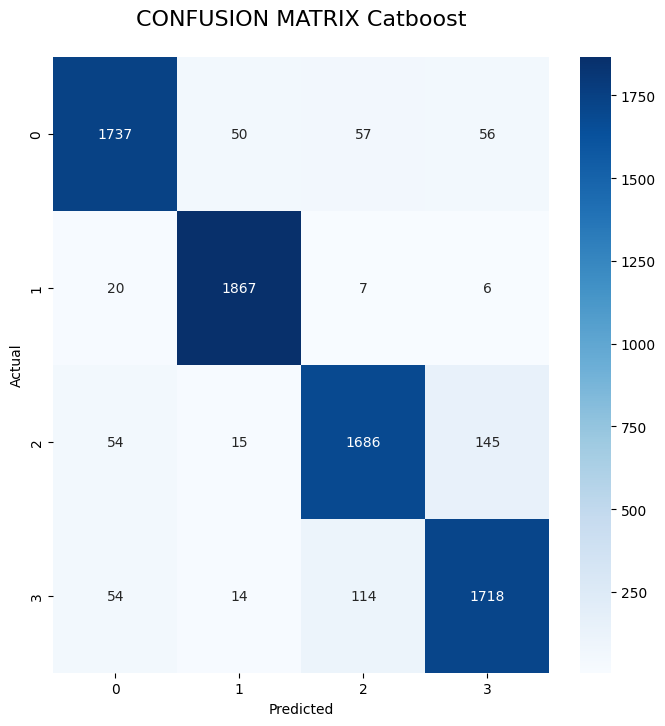

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX Catboost\n", size=16)

In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.90      0.89      0.90      1900
           4       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



In [ ]:
clf = LogisticRegression(C=15, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)
y_pred = clf.predict(bow_test)

In [ ]:
#c = 15
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9221052631578948
F1 Score (Micro) = 0.9221052631578948
F1 Score (Macro) = 0.9219463254905329


Text(0.5, 1.0, 'CONFUSION MATRIX LR\n')

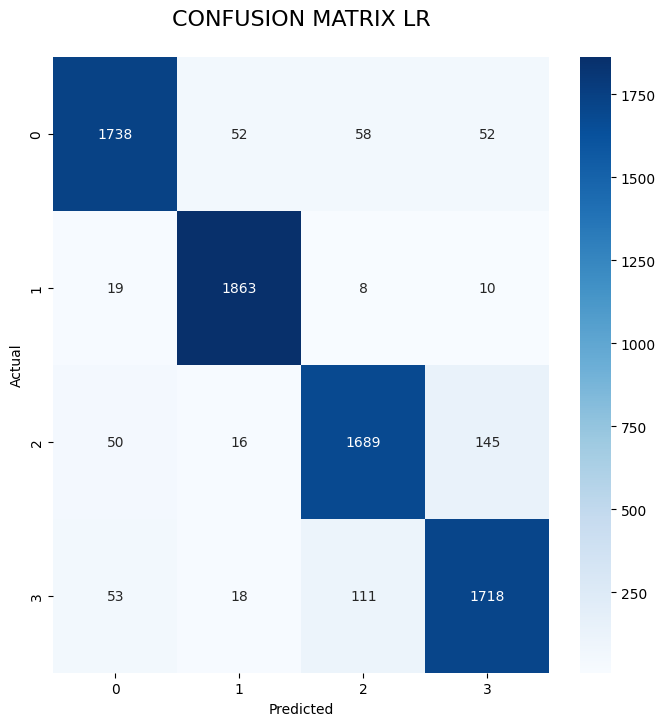

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX LR\n", size=16)

In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.91      0.89      0.90      1900
           4       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Эксперимент 6 (Токен+удаление стоп-слов + стемминг)

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-2, 1e2, log=True)

    clf = LogisticRegression(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-20 14:55:14,317] A new study created in memory with name: no-name-59b3748d-3db7-4c3a-a3ac-9c11a242c510
[I 2023-05-20 14:59:14,120] Trial 0 finished with value: 0.9175152243594311 and parameters: {'svc_c': 0.5082106698887904}. Best is trial 0 with value: 0.9175152243594311.
[I 2023-05-20 15:01:34,533] Trial 1 finished with value: 0.9166176540880673 and parameters: {'svc_c': 0.08676506854811}. Best is trial 0 with value: 0.9175152243594311.
[I 2023-05-20 15:04:11,379] Trial 2 finished with value: 0.9170407207479778 and parameters: {'svc_c': 0.13386470973472356}. Best is trial 0 with value: 0.9175152243594311.
[I 2023-05-20 15:07:00,650] Trial 3 finished with value: 0.9171672174992268 and parameters: {'svc_c': 0.12850969011163044}. Best is trial 0 with value: 0.9175152243594311.
[I 2023-05-20 15:08:40,743] Trial 4 finished with value: 0.912944914664319 and parameters: {'svc_c': 0.027073899395755198}. Best is trial 0 with value: 0.9175152243594311.
[I 2023-05-20 15:10:13,901] Tr

FrozenTrial(number=0, state=TrialState.COMPLETE, values=[0.9175152243594311], datetime_start=datetime.datetime(2023, 5, 20, 14, 55, 14, 325743), datetime_complete=datetime.datetime(2023, 5, 20, 14, 59, 14, 120063), params={'svc_c': 0.5082106698887904}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'svc_c': FloatDistribution(high=100.0, log=True, low=0.01, step=None)}, trial_id=0, value=None)


In [ ]:
bow_data = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


In [ ]:
clf = LinearSVC(C=0.5, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)
y_pred = clf.predict(bow_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9211842105263158
F1 Score (Micro) = 0.9211842105263158
F1 Score (Macro) = 0.9210162478876676


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.93      0.91      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.90      0.88      0.89      1900
           4       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX SVC\n')

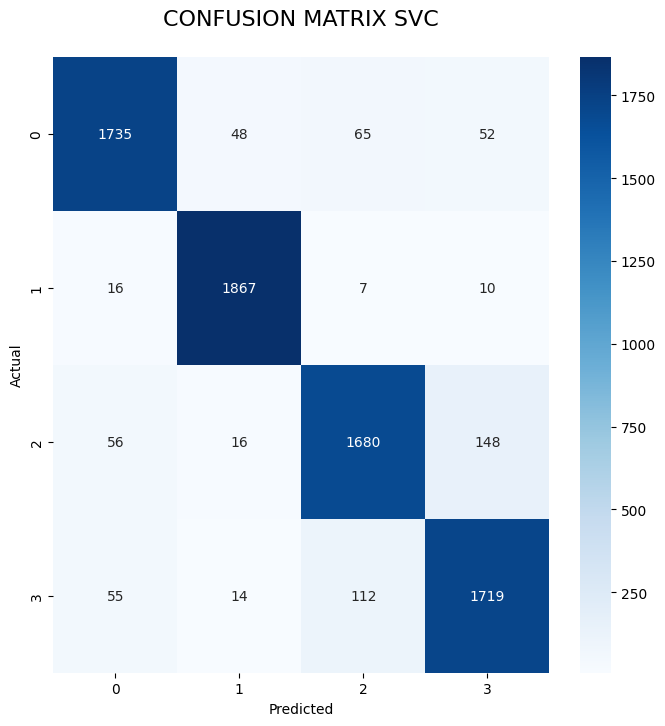

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX SVC\n", size=16)

In [ ]:
clf = MultinomialNB().fit(bow_data, labels)
y_pred = clf.predict(bow_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9122368421052631
F1 Score (Micro) = 0.9122368421052631
F1 Score (Macro) = 0.9119993933544843


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.92      0.90      0.91      1900
           2       0.95      0.98      0.97      1900
           3       0.88      0.88      0.88      1900
           4       0.89      0.89      0.89      1900

    accuracy                           0.91      7600
   macro avg       0.91      0.91      0.91      7600
weighted avg       0.91      0.91      0.91      7600



In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("lr_c", 1e-1, 1e2, log=True)

    clf = LogisticRegression(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-20 16:18:52,596] A new study created in memory with name: no-name-04cc3e87-3049-4664-88ac-da3b775dc579
[I 2023-05-20 16:21:49,997] Trial 0 finished with value: 0.9168304859552838 and parameters: {'lr_c': 0.18984511392328962}. Best is trial 0 with value: 0.9168304859552838.
[I 2023-05-20 16:27:14,549] Trial 1 finished with value: 0.9173388933241017 and parameters: {'lr_c': 15.13491329311141}. Best is trial 1 with value: 0.9173388933241017.
[I 2023-05-20 16:32:08,970] Trial 2 finished with value: 0.9170878824751948 and parameters: {'lr_c': 8.853182201325872}. Best is trial 1 with value: 0.9173388933241017.
[I 2023-05-20 16:38:15,839] Trial 3 finished with value: 0.917504767698503 and parameters: {'lr_c': 27.546780887895892}. Best is trial 3 with value: 0.917504767698503.
[I 2023-05-20 16:42:09,393] Trial 4 finished with value: 0.9175560216117757 and parameters: {'lr_c': 1.4037500132148648}. Best is trial 4 with value: 0.9175560216117757.
[I 2023-05-20 16:46:06,128] Trial 5 fin

FrozenTrial(number=4, state=TrialState.COMPLETE, values=[0.9175560216117757], datetime_start=datetime.datetime(2023, 5, 20, 16, 38, 15, 841058), datetime_complete=datetime.datetime(2023, 5, 20, 16, 42, 9, 393313), params={'lr_c': 1.4037500132148648}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr_c': FloatDistribution(high=100.0, log=True, low=0.1, step=None)}, trial_id=4, value=None)


In [ ]:
clf = LogisticRegression(C=1.5, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)
y_pred = clf.predict(bow_test)

In [ ]:
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9210526315789473
F1 Score (Micro) = 0.9210526315789473
F1 Score (Macro) = 0.9209109765605415


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.93      0.92      0.92      1900
           2       0.96      0.98      0.97      1900
           3       0.90      0.89      0.89      1900
           4       0.89      0.90      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX LR\n')

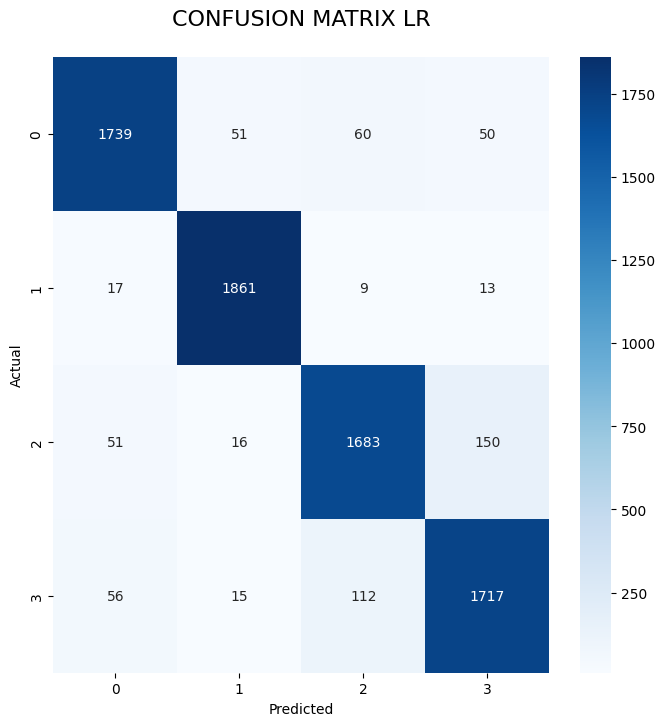

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX LR\n", size=16)

Эксперимент 7 (Токен + стемминг)

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-21 06:44:40,026] A new study created in memory with name: no-name-de03dd43-9bce-407f-af79-661d95d68271
[I 2023-05-21 06:45:23,260] Trial 0 finished with value: 0.9168669151134929 and parameters: {'svc_c': 0.1457317890512228}. Best is trial 0 with value: 0.9168669151134929.
[I 2023-05-21 06:46:49,688] Trial 1 finished with value: 0.916003330187622 and parameters: {'svc_c': 0.3486122283515321}. Best is trial 0 with value: 0.9168669151134929.
[I 2023-05-21 06:50:03,782] Trial 2 finished with value: 0.9150507316377737 and parameters: {'svc_c': 0.8701981295032621}. Best is trial 0 with value: 0.9168669151134929.


In [ ]:
bow_data = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])
bow_data

<120000x1136670 sparse matrix of type '<class 'numpy.int64'>'
	with 7795654 stored elements in Compressed Sparse Row format>

In [ ]:
clf = LinearSVC(C=0.1, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)
y_pred = clf.predict(bow_test)

In [ ]:
# 0.1
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9226315789473685
F1 Score (Micro) = 0.9226315789473686
F1 Score (Macro) = 0.9225062271886556


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.91      0.93      1900
           2       0.96      0.98      0.97      1900
           3       0.90      0.89      0.89      1900
           4       0.90      0.91      0.90      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX SVC\n')

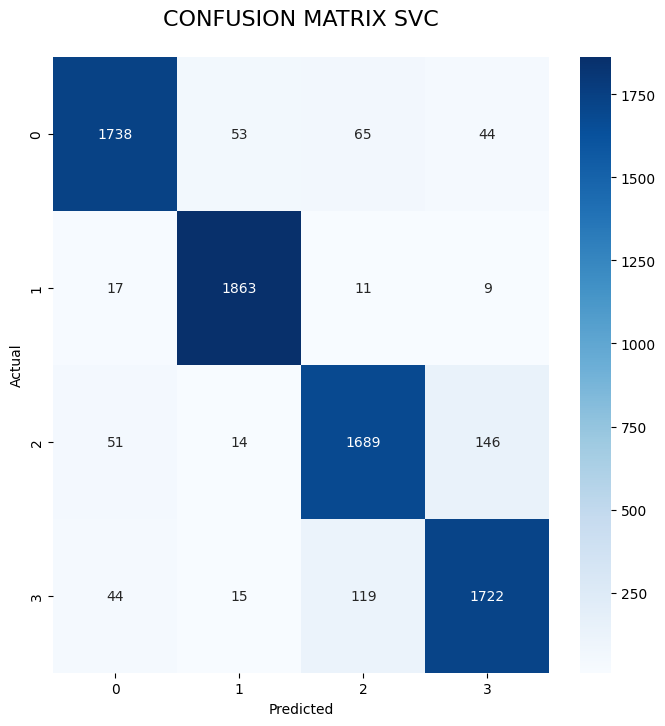

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX SVC\n", size=16)

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("lr_c", 1e-1, 1e2, log=True)

    clf = LogisticRegression(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-21 08:06:07,596] A new study created in memory with name: no-name-b3807769-0e27-4646-9282-ff3e1bdbd56b
[I 2023-05-21 08:19:09,244] Trial 0 finished with value: 0.9157735359135724 and parameters: {'lr_c': 47.70266313205785}. Best is trial 0 with value: 0.9157735359135724.
[I 2023-05-21 08:26:22,889] Trial 1 finished with value: 0.9164398208758501 and parameters: {'lr_c': 0.6246566780084875}. Best is trial 1 with value: 0.9164398208758501.
[I 2023-05-21 08:34:50,781] Trial 2 finished with value: 0.9165317805023033 and parameters: {'lr_c': 1.291117579353017}. Best is trial 2 with value: 0.9165317805023033.
[I 2023-05-21 08:42:51,758] Trial 3 finished with value: 0.9164036324605779 and parameters: {'lr_c': 0.9997899629085506}. Best is trial 2 with value: 0.9165317805023033.
[I 2023-05-21 08:52:40,786] Trial 4 finished with value: 0.9166505400396936 and parameters: {'lr_c': 4.2517971750241035}. Best is trial 4 with value: 0.9166505400396936.
[I 2023-05-21 09:03:37,187] Trial 5 fi

FrozenTrial(number=7, state=TrialState.COMPLETE, values=[0.9166936455886555], datetime_start=datetime.datetime(2023, 5, 21, 9, 15, 30, 368944), datetime_complete=datetime.datetime(2023, 5, 21, 9, 22, 32, 951732), params={'lr_c': 0.5287863782098247}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'lr_c': FloatDistribution(high=100.0, log=True, low=0.1, step=None)}, trial_id=7, value=None)


In [ ]:
clf = LogisticRegression(C=2, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)
y_pred = clf.predict(bow_test)

NameError: ignored

In [ ]:
# 2
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

NameError: ignored

In [ ]:
# 1
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9192105263157895
F1 Score (Micro) = 0.9192105263157895
F1 Score (Macro) = 0.9191023405959673


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.91      0.92      1900
           2       0.95      0.98      0.96      1900
           3       0.89      0.89      0.89      1900
           4       0.89      0.90      0.89      1900

    accuracy                           0.92      7600
   macro avg       0.92      0.92      0.92      7600
weighted avg       0.92      0.92      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX SVC\n')

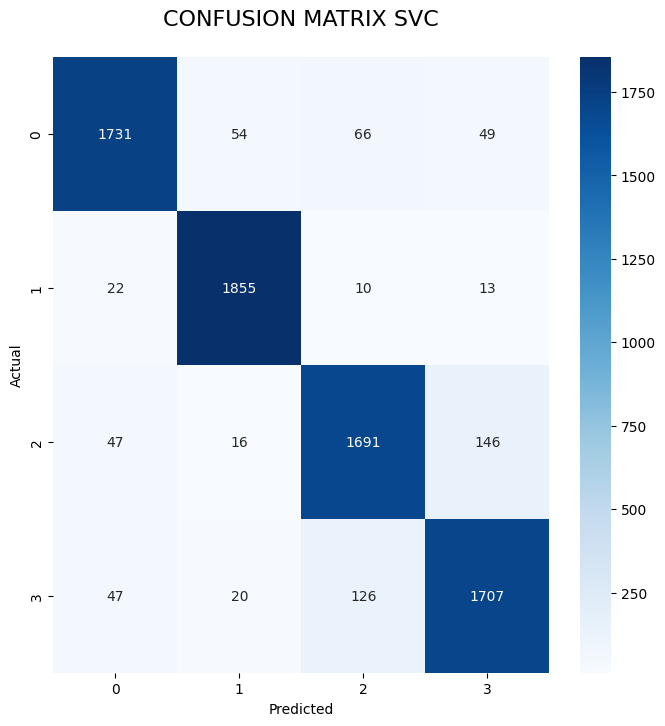

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX SVC\n", size=16)

Эксперимент 7 (Токен + удаление стоп-слов)

In [ ]:
def objective(trial):
    global bow_train, y_train, bow_valid, y_valid

    c = trial.suggest_float("svc_c", 1e-1, 1e2, log=True)

    clf = LinearSVC(C=c, random_state=3, class_weight='balanced', max_iter=100000)
    clf.fit(bow_train, y_train)

    return metrics.f1_score(clf.predict(bow_valid), y_valid, average='macro')


study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=10)
print(study.best_trial)

[I 2023-05-21 15:33:03,819] A new study created in memory with name: no-name-55684c3b-805f-4216-911c-cdc6f013cf2c
[I 2023-05-21 15:40:19,155] Trial 0 finished with value: 0.9183464903507429 and parameters: {'svc_c': 2.8695942224091424}. Best is trial 0 with value: 0.9183464903507429.
[I 2023-05-21 15:43:14,155] Trial 1 finished with value: 0.9186378291863493 and parameters: {'svc_c': 1.2863613426041722}. Best is trial 1 with value: 0.9186378291863493.
[I 2023-05-21 15:46:42,400] Trial 2 finished with value: 0.9186378291863493 and parameters: {'svc_c': 1.2724717133521386}. Best is trial 1 with value: 0.9186378291863493.
[I 2023-05-21 15:47:25,449] Trial 3 finished with value: 0.9198826584654801 and parameters: {'svc_c': 0.28702322201558317}. Best is trial 3 with value: 0.9198826584654801.
[I 2023-05-21 16:22:58,979] Trial 4 finished with value: 0.9180548357745333 and parameters: {'svc_c': 15.302019489087337}. Best is trial 3 with value: 0.9198826584654801.
[I 2023-05-21 16:24:22,547] Tr

In [ ]:
bow_data = bow_counts.fit_transform(train['content'])
bow_test = bow_counts.transform(test['content'])
bow_data

<120000x1503830 sparse matrix of type '<class 'numpy.int64'>'
	with 5463682 stored elements in Compressed Sparse Row format>

In [ ]:
clf = LinearSVC(C=0.1, random_state=3, class_weight='balanced', max_iter=100000).fit(bow_data, labels)
y_pred = clf.predict(bow_test)

In [ ]:
# 0.1
accuracy = metrics.accuracy_score(test_labels, y_pred)
f1_score_micro = metrics.f1_score(test_labels, y_pred, average='micro')
f1_score_macro = metrics.f1_score(test_labels, y_pred, average='macro')
print(f"Accuracy Score = {accuracy}")
print(f"F1 Score (Micro) = {f1_score_micro}")
print(f"F1 Score (Macro) = {f1_score_macro}")

Accuracy Score = 0.9251315789473684
F1 Score (Micro) = 0.9251315789473684
F1 Score (Macro) = 0.924932452837105


In [ ]:
print('\t\t\t\tCLASSIFICATIION METRICS\n')
print(metrics.classification_report(test_labels, y_pred))

				CLASSIFICATIION METRICS

              precision    recall  f1-score   support

           1       0.94      0.92      0.93      1900
           2       0.96      0.99      0.97      1900
           3       0.91      0.89      0.90      1900
           4       0.90      0.91      0.90      1900

    accuracy                           0.93      7600
   macro avg       0.92      0.93      0.92      7600
weighted avg       0.92      0.93      0.92      7600



Text(0.5, 1.0, 'CONFUSION MATRIX SVC\n')

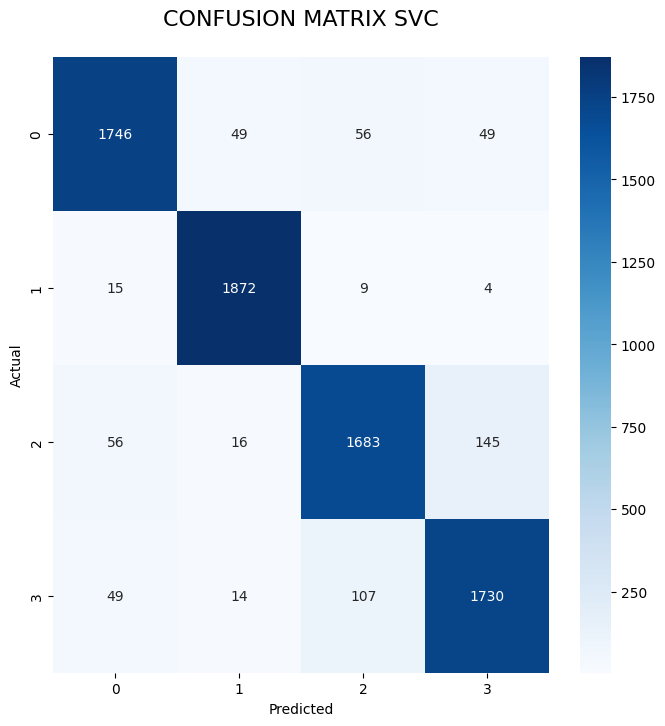

In [ ]:
conf_mat = metrics.confusion_matrix(test_labels, y_pred)
fig, ax = plt.subplots(figsize=(8,8))
sns.heatmap(conf_mat, annot=True, cmap="Blues", fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title("CONFUSION MATRIX SVC\n", size=16)